# Chatbot Test Notebook

This notebook is designed to test and experiment with the functionality of the chatbot implemented in the `rag_swimrules` project. It showcases various scenarios and evaluates the performance of the chatbot.

In [1]:
import textwrap
import json
import pandas as pd
import time
import matplotlib.pyplot as plt

from langchain.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from langchain_chroma.vectorstores import Chroma
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

from openevals.prompts import CORRECTNESS_PROMPT
from openevals.llm import create_llm_as_judge


Unable to revert mtime: /Library/Fonts
Matplotlib is building the font cache; this may take a moment.


In [2]:


swimming_rules_template = """You are an expert swimming rules assistant trained on FINA and competitive swimming regulations. 
Your answers must be precise, factual, and based only on the provided rules. Follow these guidelines:

1. Answer ONLY using the verified rules provided below
2. DO NOT use information from any other sources, including the internet or personal knowledge.
3. if an action is not explicitly prohibited in the rules, assume it is allowed.
4. if an action is not explicity mentioned, assume it is allowed.
5. if an action is explicitly stated in the rule, assume it is allowed.
6. A disqualification msut be based on a specific rule violation and cannot be implied.
7. If the information isn't in the rules, say "I don't have that rule in my current documentation"
8. Keep answers concise but complete
9. Reference specific rule numbers when possible

Relevant swimming rules:
{context}

Question: {question}

Answer:"""

SWIMMING_RULES_PROMPT = PromptTemplate(
    template=swimming_rules_template,
    input_variables=["context", "question"]
)


In [3]:
# reaad situations from json file
with open("../raw_data/swimming_situations.json") as f:
    swimming_situations = json.load(f)

swimming_situations

[{'sitiuation_id': 9,
  'prompt': 'A breaststroke swimmer moves their hands in a sculling or flipper movement at the end of the first arm stroke, both after the start and after the turn. Should they be disqualified?',
  'target': "No, the swimmer should not be disqualified. This is legal provided, 'All movements of the arms shall be simultaneous without alternating movement.' A sculling motion of the hands, only as a part of the arm stroke, is not considered the beginning of a new stroke."},
 {'sitiuation_id': 10,
  'prompt': 'In a 9-10 100 yard breaststroke event, a swimmer completes 50 yards and, thinking that the race is over, pushes back from the wall to read the scoreboard. At this point, realizing that the race is only halfway over, the swimmer returns to the wall, pushes off on the breast, and completes the required distance in good form. What call, if any, should be made?',
  'target': 'The swimmer left the wall on the back and then returned to the wall before resuming the stro

In [4]:
# Initialize embeddings model (ensure the same model used during creation)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# retretieve the relevant rules from your database or knowledge base
# Load the existing Chroma vector store
persist_directory = "../db/swim_rules_semantic"
vector_store = Chroma(persist_directory=persist_directory, embedding_function=embeddings)

# Create a retriever from the vector store
retriever = vector_store.as_retriever(search_kwargs={"k": 10})



In [5]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_tokens=1000
)


In [6]:
for situation in swimming_situations:
    print(f"Situation: {situation}")

Situation: {'sitiuation_id': 9, 'prompt': 'A breaststroke swimmer moves their hands in a sculling or flipper movement at the end of the first arm stroke, both after the start and after the turn. Should they be disqualified?', 'target': "No, the swimmer should not be disqualified. This is legal provided, 'All movements of the arms shall be simultaneous without alternating movement.' A sculling motion of the hands, only as a part of the arm stroke, is not considered the beginning of a new stroke."}
Situation: {'sitiuation_id': 10, 'prompt': 'In a 9-10 100 yard breaststroke event, a swimmer completes 50 yards and, thinking that the race is over, pushes back from the wall to read the scoreboard. At this point, realizing that the race is only halfway over, the swimmer returns to the wall, pushes off on the breast, and completes the required distance in good form. What call, if any, should be made?', 'target': 'The swimmer left the wall on the back and then returned to the wall before resumi

In [7]:
# setup evaluator
response_evaluator = create_llm_as_judge(
    prompt=CORRECTNESS_PROMPT,
    model="openai:gpt-4o",
    feedback_key="correctness"
)

In [8]:

test_results = []
for situation in swimming_situations:
    query = situation["prompt"]
    test_case = {"question": query, "situation": situation["sitiuation_id"]}
    print()
    print(textwrap.fill(f"\n>>>SITUATION: {situation['sitiuation_id']} QUERY: {query}", width=80))
    

    # Use the retriever to get relevant documents
    docs = retriever.get_relevant_documents(query)

    # Combine the retrieved documents into a context string
    context = "\n".join([doc.page_content for doc in docs])
    # print(textwrap.fill(f"\n>>>CONTEXT:\n{context}", width=80))
    # If no documents were retrieved, provide a default message

    # Create the prompt template
    prompt = SWIMMING_RULES_PROMPT.format(context=context, question=query)

    start_time = time.time()
    response = llm(prompt)
    test_case["query_time"] = time.time() - start_time

    start_time = time.time()
    correctness_score = response_evaluator(inputs=query, outputs=response.content, reference_outputs=situation["target"])
    test_case["response_eval_time"] = time.time() - start_time

    test_case.update({
        "llm_response": response.content,
        "correctness_score": correctness_score["score"],
        "feedback": correctness_score["comment"],
        "target": situation["target"]
    })

    # Word wrap the response content if the line is longer than 80 characters
    wrapped_response = textwrap.fill(response.content, width=80)
    print(f">>>LLM RESPONSE: {wrapped_response}")
    print(f">>>TARGET: {textwrap.fill(situation['target'], width=80)}")

    print(f">>>CORRECTNESS SCORE: {correctness_score['key']}  {correctness_score['score']}")
    print(f"FEEDBACK: {textwrap.fill(correctness_score['comment'], width=80)}")

    test_results.append(test_case)




 >>>SITUATION: 9 QUERY: A breaststroke swimmer moves their hands in a sculling
or flipper movement at the end of the first arm stroke, both after the start and
after the turn. Should they be disqualified?


/var/folders/8_/h2tjc94d2y5fwx8dhbcrnbfc0000gn/T/ipykernel_20471/2693908529.py:10: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(query)
/var/folders/8_/h2tjc94d2y5fwx8dhbcrnbfc0000gn/T/ipykernel_20471/2693908529.py:21: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm(prompt)


>>>LLM RESPONSE: No, the swimmer should not be disqualified. According to rule 101.2.2, after the
start and after each turn, the swimmer may take one arm stroke completely back
to the legs. The hands must be pushed forward together from the breast on,
under, or over the water, and the hands shall not be brought back beyond the hip
line, except during the first stroke after the start and each turn. There is no
specific prohibition against a sculling or flipper movement at the end of the
first arm stroke, so it is allowed.
>>>TARGET: No, the swimmer should not be disqualified. This is legal provided, 'All
movements of the arms shall be simultaneous without alternating movement.' A
sculling motion of the hands, only as a part of the arm stroke, is not
considered the beginning of a new stroke.
>>>CORRECTNESS SCORE: correctness  True
FEEDBACK: The provided answer correctly states that the swimmer should not be disqualified
and gives an explanation in line with the rules. It clarifies that d

In [9]:
test_results_df = pd.DataFrame(test_results)
test_results_df

,question,situation,query_time,response_eval_time,llm_response,correctness_score,feedback,target
0,A breaststroke swimmer moves their hands in a ...,9,1.703555,2.394811,"No, the swimmer should not be disqualified. Ac...",True,The provided answer correctly states that the ...,"No, the swimmer should not be disqualified. Th..."
1,"In a 9-10 100 yard breaststroke event, a swimm...",10,0.632415,2.511264,I don't have that rule in my current documenta...,False,The provided output indicates a lack of availa...,The swimmer left the wall on the back and then...
2,After a deep forward start in the breaststroke...,23,1.617250,2.528005,"Based on the provided rules, the disqualificat...",True,The output in question states that the swimmer...,"No. The rule states, 'After the start and each..."
3,A swimmer in the 100 yard butterfly moves too ...,37,1.157119,3.031172,"Yes, this is a valid disqualification. Accordi...",True,The output is evaluated against the provided r...,"This is a correct call. The rule states, “Both..."


75.0 -0.05 0.0
25.0 -0.05 75.0


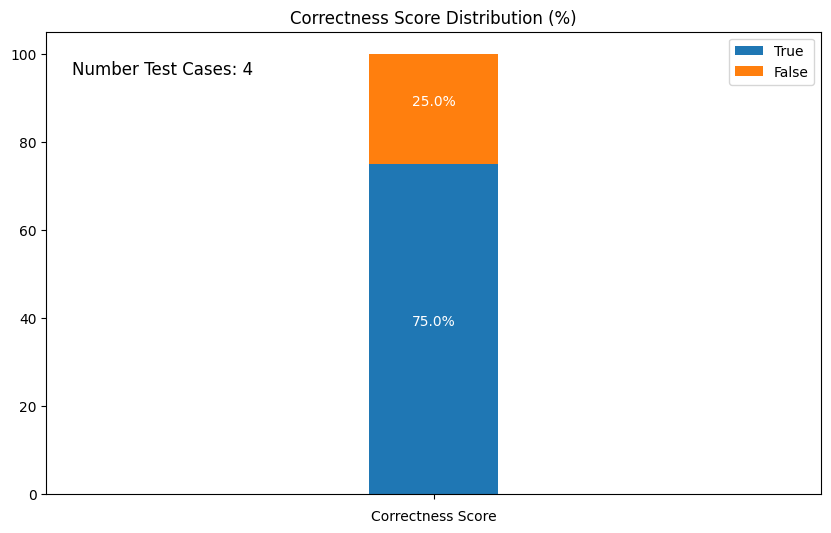

In [90]:
import pandas as pd
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 6))
# Set the figure size
# Calculate value counts and normalize to percentages
value_counts = test_results_df['correctness_score'].value_counts(normalize=True).mul(100)


# Create a stacked bar plot
df = pd.DataFrame(value_counts).T
df.columns = value_counts.index.astype(str).to_list()
df.rename(index={"proportion": 'correctness_score'}, inplace=True)
df = df[["True", "False"]]
df.plot.bar(stacked=True, ax=ax, width=0.1)
plt.title('Correctness Score Distribution (%)')
ax.set_xticklabels([], rotation=0)
plt.xlabel('Correctness Score')


# label the bars with percentage values
value_patches = zip(value_counts, ax.patches)
for value, patch in value_patches:
    height = patch.get_height()
    print(height, patch.get_x(), patch.get_y())
    ax.annotate(f'{value:.1f}%', 
                xy=(patch.get_x() + patch.get_width() / 2, patch.get_y() + value / 2), 
                ha='center', va='bottom', fontsize=10, color="white")
    
# annotate chart with number of test cases
total_test_cases = len(test_results_df)
ax.annotate(f'Number Test Cases: {total_test_cases}', 
            xy=(0.15, 0.9), 
            ha='center', va='bottom', fontsize=12, color="black", xycoords='axes fraction')


# Create stacked bar plot

plt.show()

In [59]:

df


,True,False
correctness_score,75.0,25.0


In [64]:
list(ax.patches)

In [56]:
value_counts.index.astype(str).to_list()

['True', 'False']

In [84]:
test_results_df.shape


(4, 9)